# Rating Curve Regression Calculator - Template

This notebook is used to create rating curves for each site in Logan GAMUT. 
The analysis follows Herschy 2009.
A power low regression is used of the form $$Q = (h + a)^{n}$$
where $Q$ is discharge, $h$ is stage (in this case 'water surface elevation'), and $a$ is the effective depth of zero flow

In [1]:
# -*- coding: utf-8 -*-

#Interactive plotting
%matplotlib Widget

#Import various modules
import numpy as np
from scipy import optimize  #Used to fit the regression
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider  #Used to interactively find 'a'
import pandas as pd  #Used for general data manipulation

Import data from excel file

In [2]:
#Import Data
dpath ='RatingCurveData_LR_MS.csv'
disdata = pd.read_csv(dpath, index_col = 0)

Initial plotting of data in both normal and log-log space. Use to identify breaks associated with changes in stage-discharge control.

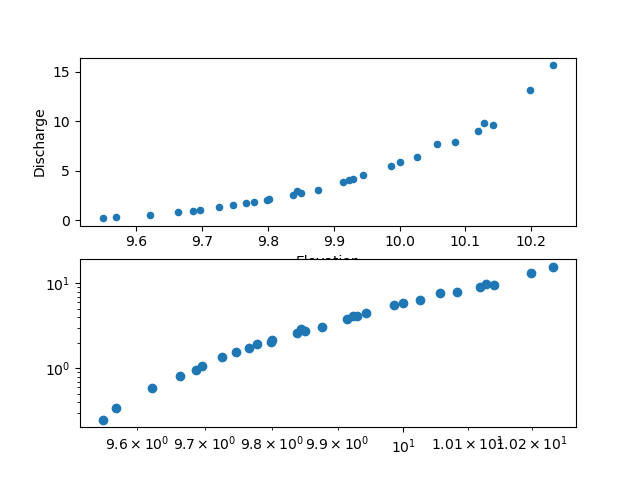

In [5]:
#Set up subplots
fig1, axs1 = plt.subplots(2,1)

#Plot normal
disdata.plot.scatter(x='Elevation',y = 'Discharge',ax = axs1[0])
#Plot Loglog
axs1[1].loglog(disdata.Elevation,disdata.Discharge,'o')

**Initial Analysis**: 

Effective height of zero flow:
-------------------------------
If data indicates there is a change in control necessitating multiple regressions on subsets of data, select a subset of data. otherwise just copy all of dataset.

In [6]:
#Select data for analysis or copy all data
#disdata2 = disdata.loc[disdata.Elevation > 6.25].copy()  #I have to add the copy statement to avoid a warning in other cells
disdata2 = disdata.copy()

Use slider to adjust value of $a$. Following Herschy, $a$ should be approximately the elevation of the thalweg for for channel controls or the elevation of zero flow for section controls.

In [9]:
#Prep data for plot
ainit = disdata2.Elevation.min() - 1 #initial value of a = to min stage - 1m
disdata2['eheight'] = disdata2.Elevation - ainit
logdata = np.log10(disdata2) 

#Set up plot
x = logdata.eheight.values
y = logdata.Discharge.values
fig = plt.gcf()
ax1 = plt.gca()
lines, = plt.plot(x,y,'*') #This is a tuple of lines (that is what the comma signifies)
plt.subplots_adjust(bottom=0.25) #This makes room under the plot for the slider

#Initialize slider widget
axslide = plt.axes([0.25, 0.1, 0.65, 0.03],facecolor='lightgoldenrodyellow') #Slider axis??
aval = Slider(axslide,'a',ainit,disdata2.Elevation.min(),valinit=ainit)

#Update function
def update(val):
    newa = aval.val
    disdata2.eheight = disdata2.Elevation - newa
    newvals = np.log10(disdata2.eheight.values)
    xmin = newvals.min()
    xmax = newvals.max()
    lines.set_xdata(newvals)
    ax1.set_xlim(xmin,xmax)
    fig.canvas.draw_idle()

aval.on_changed(update)

0

Regression
----------
This section computes the least squares power function regression on the data using Scipy's optimization library. Ideally, the errors in the measurements would be incorporated into the regression using a "weighted least squares" or similar method. However, preliminary research indicates that the log transformation of the power law required for linearization makes handling the uncertainty associated with measurements unclear. So, for now all measurements are assumed to have the same variance. See SciPy example for more: http://scipy-cookbook.readthedocs.io/items/FittingData.html#fitting-a-power-law-to-data-with-errors

In [ ]:
#Recalculate logdata since the slider widget doesn't update it
logdata = np.log10(disdata2) 

#Error 
#disdata2['error'] = (disdata2.Uncertainty/100)
disdata2['error'] = disdata2.Uncertainty*0 + 1 #A vector of ones for testing w/o error

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x  #Equation for line
errfunc = lambda p, x, y, err: (y - fitfunc(p, x))/err

#Run optimization
pinit = [1.0, -1.0]  #initial starting point
out = optimize.leastsq(errfunc, pinit,
                       args=(logdata.eheight, logdata.Discharge, disdata2.error), full_output=1)

#Get output
pfinal = out[0]

#Calculate final coefficients, convert back from log space
a = disdata2.Elevation.iloc[1] - disdata2.eheight.iloc[1]
C = 10.0**pfinal[0]  
n = pfinal[1]

#Test plot
h = np.linspace(a,(a+2),100)
calcdisch = C*(h-a)**n

ax1 = disdata2.plot.scatter(x = 'Elevation', y = 'Discharge', yerr = ((disdata2.Uncertainty/100)*disdata2.Discharge))
ax1.plot(h,calcdisch)

print('Equation coefficients:\n C = {}, a = {}, n = {}'.format(C,a,n))

Final equation: 
---------------
$Q = X(h-X)^{X}$

**Analysis**: 

Reference:
----------
Herschy, R.W., 2009, Streamflow Measurement, Third Ed.